In [1]:
%matplotlib inline

In [2]:
import adolc

In [3]:
from adapt_utils.case_studies.tohoku.options import TohokuOkadaOptions

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

# Inverting the Okada model

In this notebook, $\mathbf m$ contains parameters associated with an Okada function representation on an array of subfaults.
That is, the initial surface elevation $\eta_0$ is given by

$$
    \eta_0(\mathbf x)=\mathrm{Okada}(\mathbf m),
$$

where $\mathrm{Okada}$ denotes the Okada model.

We can use `pyadolc` to differentiate through the Okada model, giving

$$
    \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}\:\widetilde{\mathrm m},
$$

for some choice of control parameters, $\widetilde{\mathrm m}$.
With an appropriate choice of seed vectors (i.e. a seed matrix), we can obtain the gradient

$$
    \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}.
$$

(See previous notebook for details.)
Henceforth let's drop the subscript zero and instead use $\eta_{ij}$ to indicate the $(i,j)^{th}$ entry on the Okada grid.

Suppose we have a source field $\eta^\star$.
We would like to establish Okada parameters $\mathbf m$ so that $\mathrm{Okada}(\mathbf m)\approx\eta^\star$.
One approach is to solve an optimisation problem of the form

$$
    \min J(\eta;\mathbf m)\quad\text{such that}\quad\eta=\mathrm{Okada}(\mathbf m),
$$

where $J$ quantifies how well $\eta$ matches $\eta^\star$ in some sense.
We opt for the mean square error as our error measure:

$$
    J(\eta;\mathbf m)=\frac1{N^2}\sum_{i=0}^{N-1}\sum_{j=0}^{N-1}(\eta_{ij}-\eta_{ij}^\star)^2.
$$

where the Okada grid has dimensions $N\times N$.

There are potentially redundancies in the Okada source model in the sense that very similar fields can be generated using different combinations of the input parameters.
If so then there could be uniqueness/local minima issues when applying gradient-based optimisation routines.
This notebook explores whether or not we need to worry.

### Initialisation

Set parameters and create a `TohokuOkadaOptions` object to hold them.
Apply the Okada model with default input parameters to give the field we want to invert for, stored in memory as `eta`.

In [60]:
kwargs = {
    'okada_grid_resolution': 51,
    'debug': False,
}
plotting_kwargs = {
    'cmap': 'coolwarm',
    'levels': 50,
}
nonlinear = False

In [61]:
op = TohokuOkadaOptions(**kwargs)
op.create_topography()
N = op.N
X = op.fault.dtopo.X
Y = op.fault.dtopo.Y
eta = op.fault.dtopo.dZ.copy()
m_orig = op.get_input_vector()
np.save("notebook_4_m_orig", m_orig)

### Differentatiate the source model

Perturb the control parameters with some Normal random noise so that the source is different from that used to generate the gauge timeseries data.
This effectively means 'choose an initial guess'.

In [8]:
kwargs['control_parameters'] = op.control_parameters
for control in op.active_controls:
    size = np.shape(op.control_parameters[control])
    kwargs['control_parameters'][control] += np.random.normal(loc=0, scale=10, size=size)

When setting the free surface initial condition using the Okada model, we tell `pyadolc` to annotate its tape.
For this application we need to modify the way that the tape is annotated by default.

In [9]:
class TohokuOkadaInversionOptions(TohokuOkadaOptions):
    """
    A subclass of :class:`TohokuOkadaOptions` which adds an extra step to the annotation. Namely, the mean
    square error between the computed surface and the 'true solution' is computed by looping over the vertices
    of the Okada grid.
    """
    
    def _create_topography_active(self, tag=0, separate_faults=False):
        
        # Sanitise kwargs
        assert isinstance(tag, int)
        assert tag >= 0
        for control in self.active_controls:
            assert control in self.all_controls
        
        # Initialise tape
        adolc.trace_on(tape_tag)

        # Read parameters and mark active variables as independent
        msg = "Subfault {:d}: shear modulus {:4.1e} Pa, seismic moment is {:4.1e}"
        for i, subfault in enumerate(self.subfaults):
            for control in self.all_controls:
                if control in self.active_controls:
                    subfault.__setattr__(control, adolc.adouble(self.control_parameters[control][i]))
                    adolc.independent(subfault.__getattribute__(control))
                else:
                    subfault.__setattr__(control, self.control_parameters[control][i])
            self.print_debug(msg.format(i, subfault.mu, subfault.Mo().val))

        # Create the topography, thereby calling Okada
        self.print_debug("SETUP: Creating topography using Okada model...")
        self.fault.create_dtopography(verbose=self.debug, active=True)
        self.print_debug("SETUP: Done!")

        # Compute quantity of interest
        self.J_subfaults = [0.0 for j in range(self.N)]
        for j in range(self.N):
            for i in range(self.N):
                self.J_subfaults[j] += (eta[i, j] - self.fault.dtopo.dZ_a[i, j])**2
            self.J_subfaults[j] /= op.N**2

        self.J = sum(self.J_subfaults)
            
        # Mark dependence
        if separate_faults:
            for j in range(self.N):
                adolc.dependent(self.J_subfaults[j])
        else:
            adolc.dependent(self.J)
        adolc.trace_off()

Create the topography once in order to annotate the tape

In [10]:
tape_tag = 0
op = TohokuOkadaInversionOptions(**kwargs)
op.create_topography(annotate=True, tag=tape_tag)
op.get_seed_matrices()  # these can be reused over and over
print("QoI = {:.4e}".format(op.J.val))

QoI = 4.9229e-01


Create some arrays to keep track of the optimisation routine

In [32]:
op.J_progress = []
op.dJdm_progress = []

Sum over all subfaults to get the total QoI.
By unrolling the tape, we can easily express the reduced functional as a function of the active controls.
Note that we raise a flag which prepares for a subsequent reverse mode propagation.

In [33]:
def reduced_functional(m):
    """Apply the Okada model by unrolling the tape and compute the QoI."""
    J = sum(adolc.zos_forward(tape_tag, m, keep=1))
    op.J_progress.append(J)
    return J

In [34]:
J = reduced_functional(op.input_vector)
assert np.isclose(J, op.J.val)

We can propagate through the reverse mode of AD to get the gradient

In [35]:
def gradient(m):
    """Compute the gradient of the QoI with respect to the input parameters."""
    J = op.J_progress[-1]
    dJdm = adolc.fos_reverse(tape_tag, J)
    norm = np.linalg.norm(dJdm)
    op.dJdm_progress.append(norm)
    return dJdm

In [37]:
g = gradient(op.input_vector)
assert len(g) == len(op.input_vector)
print("J = {:.4e}  ||dJdm|| = {:.4e}".format(op.J_progress[-1], op.dJdm_progress[-1]))

J = 4.9229e-01  ||dJdm|| = 5.4832e-03


In [38]:
eta_pert = op.fault.dtopo.dZ.copy()

Check that the function stored to tape evaluates as it should

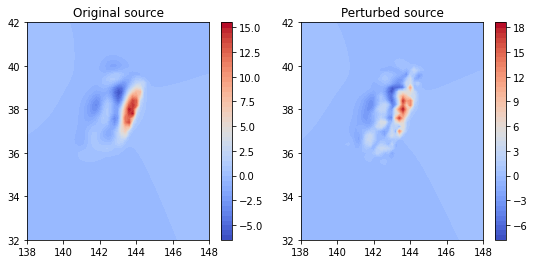

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4))
eta_pert = op.fault.dtopo.dZ.reshape(N, N)
fig.colorbar(axes[0].contourf(X, Y, eta, **plotting_kwargs), ax=axes[0]);
axes[0].set_title("Original source");
fig.colorbar(axes[1].contourf(X, Y, eta_pert, **plotting_kwargs), ax=axes[1]);
axes[1].set_title("Perturbed source");

### Taylor test

In [ ]:
from firedrake import ConvergenceError

In [ ]:
def taylor_test(m):
    print(24*"=" + "TAYLOR TEST" + 24*"=")
    delta_m = np.random.normal(loc=0.0, scale=1.0, size=len(m))
    
    # Evaluate the reduced functional and gradient at the specified control value
    Jm = reduced_functional(m)
    dJdm = gradient(m)
    
    # Check that the Taylor remainders decrease quadratically
    remainders = np.zeros(3)
    for i in range(3):
        h = pow(0.5, i)
        print("h = {:.4e}".format(h))
        J_step = reduced_functional(m+h*delta_m)
        remainders[i] = abs(J_step - Jm - h*np.dot(dJdm, delta_m))
        print("Taylor remainder = {:.4e}".format(remainders[i]))
        if i > 0:
            ratio = remainders[i-1]/remainders[i]
            try:
                assert ratio > 3.95
            except AssertionError:
                msg = "Taylor remainders do not decrease quadratically (ratio {:.4e})"
                raise ConvergenceError(msg.format(ratio))
    print(20*"=" + "TAYLOR TEST PASSED!" + 20*"=")

In [ ]:
taylor_test(op.input_vector)

### Inversion

Reset the progress arrays

In [45]:
# Reset progress arrays
op.J_progress = []
op.dJdm_progress = []

def opt_cb(m):
    """Print progress after every successful line search"""
    msg = "{:4d}: J = {:.4e}  ||dJdm|| = {:.4e}"
    print(msg.format(len(op.J_progress), op.J_progress[-1], op.dJdm_progress[-1]))

opt_parameters = {
    'maxiter': 1000,
    'disp': True,
    'gtol': 1.0e-08,
    'callback': opt_cb,
    'retall': True,
    'fprime': gradient,
}

m_opt, out = scipy.optimize.fmin_bfgs(reduced_functional, op.input_vector, **opt_parameters)

   7: J = 4.1511e-01  ||dJdm|| = 3.9643e-03 LINE SEARCH COMPLETE
   8: J = 2.7197e-01  ||dJdm|| = 1.7435e-03 LINE SEARCH COMPLETE
   9: J = 2.2119e-01  ||dJdm|| = 1.2317e-03 LINE SEARCH COMPLETE
  10: J = 1.9833e-01  ||dJdm|| = 1.1488e-03 LINE SEARCH COMPLETE
  11: J = 1.9444e-01  ||dJdm|| = 1.2109e-03 LINE SEARCH COMPLETE
  12: J = 1.9428e-01  ||dJdm|| = 1.2335e-03 LINE SEARCH COMPLETE
  13: J = 1.9428e-01  ||dJdm|| = 1.2351e-03 LINE SEARCH COMPLETE
  14: J = 1.9420e-01  ||dJdm|| = 1.2430e-03 LINE SEARCH COMPLETE
  15: J = 1.9404e-01  ||dJdm|| = 1.2547e-03 LINE SEARCH COMPLETE
  16: J = 1.9364e-01  ||dJdm|| = 1.2694e-03 LINE SEARCH COMPLETE
  17: J = 1.9258e-01  ||dJdm|| = 1.2881e-03 LINE SEARCH COMPLETE
  18: J = 1.8993e-01  ||dJdm|| = 1.3009e-03 LINE SEARCH COMPLETE
  19: J = 1.8343e-01  ||dJdm|| = 1.2784e-03 LINE SEARCH COMPLETE
  20: J = 1.6922e-01  ||dJdm|| = 1.1552e-03 LINE SEARCH COMPLETE
  21: J = 1.4460e-01  ||dJdm|| = 8.8097e-04 LINE SEARCH COMPLETE
  22: J = 1.1664e-01  ||d

 134: J = 8.8338e-03  ||dJdm|| = 5.6255e-06 LINE SEARCH COMPLETE
 135: J = 8.8253e-03  ||dJdm|| = 5.5487e-06 LINE SEARCH COMPLETE
 136: J = 8.8035e-03  ||dJdm|| = 5.4283e-06 LINE SEARCH COMPLETE
 137: J = 8.7482e-03  ||dJdm|| = 5.2465e-06 LINE SEARCH COMPLETE
 138: J = 8.6138e-03  ||dJdm|| = 5.0013e-06 LINE SEARCH COMPLETE
 139: J = 8.3213e-03  ||dJdm|| = 4.7483e-06 LINE SEARCH COMPLETE
 140: J = 7.8271e-03  ||dJdm|| = 4.5531e-06 LINE SEARCH COMPLETE
 141: J = 7.3144e-03  ||dJdm|| = 4.3369e-06 LINE SEARCH COMPLETE
 142: J = 7.0582e-03  ||dJdm|| = 4.1285e-06 LINE SEARCH COMPLETE
 143: J = 7.0068e-03  ||dJdm|| = 3.9736e-06 LINE SEARCH COMPLETE
 144: J = 7.0024e-03  ||dJdm|| = 3.8666e-06 LINE SEARCH COMPLETE
 145: J = 7.0021e-03  ||dJdm|| = 3.8284e-06 LINE SEARCH COMPLETE
 146: J = 7.0021e-03  ||dJdm|| = 3.8220e-06 LINE SEARCH COMPLETE
 147: J = 7.0021e-03  ||dJdm|| = 3.8215e-06 LINE SEARCH COMPLETE
 148: J = 7.0021e-03  ||dJdm|| = 3.8240e-06 LINE SEARCH COMPLETE
 149: J = 7.0021e-03  ||d

 261: J = 2.7196e-03  ||dJdm|| = 7.9122e-07 LINE SEARCH COMPLETE
 262: J = 2.7196e-03  ||dJdm|| = 7.9168e-07 LINE SEARCH COMPLETE
 263: J = 2.7196e-03  ||dJdm|| = 7.9224e-07 LINE SEARCH COMPLETE
 264: J = 2.7196e-03  ||dJdm|| = 7.9299e-07 LINE SEARCH COMPLETE
 265: J = 2.7195e-03  ||dJdm|| = 7.9387e-07 LINE SEARCH COMPLETE
 266: J = 2.7195e-03  ||dJdm|| = 7.9482e-07 LINE SEARCH COMPLETE
 267: J = 2.7195e-03  ||dJdm|| = 7.9568e-07 LINE SEARCH COMPLETE
 268: J = 2.7193e-03  ||dJdm|| = 7.9612e-07 LINE SEARCH COMPLETE
 269: J = 2.7189e-03  ||dJdm|| = 7.9552e-07 LINE SEARCH COMPLETE
 270: J = 2.7179e-03  ||dJdm|| = 7.9264e-07 LINE SEARCH COMPLETE
 271: J = 2.7153e-03  ||dJdm|| = 7.8505e-07 LINE SEARCH COMPLETE
 272: J = 2.7088e-03  ||dJdm|| = 7.6803e-07 LINE SEARCH COMPLETE
 273: J = 2.6926e-03  ||dJdm|| = 7.3321e-07 LINE SEARCH COMPLETE
 274: J = 2.6550e-03  ||dJdm|| = 6.7119e-07 LINE SEARCH COMPLETE
 275: J = 2.5797e-03  ||dJdm|| = 5.9341e-07 LINE SEARCH COMPLETE
 276: J = 2.4723e-03  ||d

 388: J = 1.2808e-03  ||dJdm|| = 1.9303e-07 LINE SEARCH COMPLETE
 389: J = 1.2808e-03  ||dJdm|| = 1.9323e-07 LINE SEARCH COMPLETE
 390: J = 1.2807e-03  ||dJdm|| = 1.9342e-07 LINE SEARCH COMPLETE
 391: J = 1.2807e-03  ||dJdm|| = 1.9357e-07 LINE SEARCH COMPLETE
 392: J = 1.2806e-03  ||dJdm|| = 1.9360e-07 LINE SEARCH COMPLETE
 393: J = 1.2803e-03  ||dJdm|| = 1.9343e-07 LINE SEARCH COMPLETE
 394: J = 1.2795e-03  ||dJdm|| = 1.9299e-07 LINE SEARCH COMPLETE
 395: J = 1.2776e-03  ||dJdm|| = 1.9235e-07 LINE SEARCH COMPLETE
 396: J = 1.2727e-03  ||dJdm|| = 1.9213e-07 LINE SEARCH COMPLETE
 397: J = 1.2607e-03  ||dJdm|| = 1.9407e-07 LINE SEARCH COMPLETE
 398: J = 1.2334e-03  ||dJdm|| = 1.9991e-07 LINE SEARCH COMPLETE
 399: J = 1.1826e-03  ||dJdm|| = 2.0321e-07 LINE SEARCH COMPLETE
 400: J = 1.1194e-03  ||dJdm|| = 1.8791e-07 LINE SEARCH COMPLETE
 401: J = 1.0797e-03  ||dJdm|| = 1.6400e-07 LINE SEARCH COMPLETE
 402: J = 1.0694e-03  ||dJdm|| = 1.5242e-07 LINE SEARCH COMPLETE
 403: J = 1.0682e-03  ||d

 515: J = 6.2215e-04  ||dJdm|| = 5.0957e-08 LINE SEARCH COMPLETE
 516: J = 6.2215e-04  ||dJdm|| = 5.0998e-08 LINE SEARCH COMPLETE
 517: J = 6.2215e-04  ||dJdm|| = 5.0996e-08 LINE SEARCH COMPLETE
 518: J = 6.2215e-04  ||dJdm|| = 5.0986e-08 LINE SEARCH COMPLETE
 519: J = 6.2215e-04  ||dJdm|| = 5.0979e-08 LINE SEARCH COMPLETE
 520: J = 6.2215e-04  ||dJdm|| = 5.0971e-08 LINE SEARCH COMPLETE
 521: J = 6.2215e-04  ||dJdm|| = 5.0962e-08 LINE SEARCH COMPLETE
 522: J = 6.2215e-04  ||dJdm|| = 5.0952e-08 LINE SEARCH COMPLETE
 523: J = 6.2215e-04  ||dJdm|| = 5.0943e-08 LINE SEARCH COMPLETE
 524: J = 6.2215e-04  ||dJdm|| = 5.0938e-08 LINE SEARCH COMPLETE
 525: J = 6.2215e-04  ||dJdm|| = 5.0944e-08 LINE SEARCH COMPLETE
 526: J = 6.2215e-04  ||dJdm|| = 5.0969e-08 LINE SEARCH COMPLETE
 527: J = 6.2214e-04  ||dJdm|| = 5.1029e-08 LINE SEARCH COMPLETE
 528: J = 6.2213e-04  ||dJdm|| = 5.1149e-08 LINE SEARCH COMPLETE
 529: J = 6.2210e-04  ||dJdm|| = 5.1375e-08 LINE SEARCH COMPLETE
 530: J = 6.2202e-04  ||d

In [56]:
np.save("notebook_4_m_opt", m_opt)

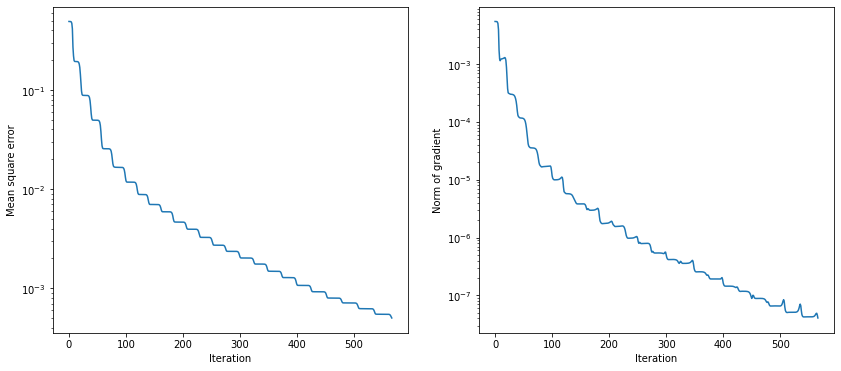

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

ax = axes[0]
ax.semilogy(op.J_progress);
ax.set_xlabel("Iteration");
ax.set_ylabel("Mean square error");

ax = axes[1]
ax.semilogy(op.dJdm_progress);
ax.set_xlabel("Iteration");
ax.set_ylabel("Norm of gradient");

Compare the optimised parameters, `m_opt`, against the original ones, `m_orig`.

In [63]:
diff = m_opt - m_orig
print("Mean square error of controls = {:.4e}".format(np.linalg.norm(diff)**2/len(m_opt)))

Mean square error of controls = 7.7252e+01


In [72]:
diff = diff.reshape(op.nx*op.ny, len(op.active_controls))
for j, row in enumerate(diff):
    print("{:3d}: {:8.4f}, {:8.4f}, {:8.4f}, {:8.4f}".format(j, *row))

  0:  -0.3081,  -2.8346,   8.9474,  -3.3076
  1:   0.8140, -10.6276,  -8.9795,   9.4825
  2:   0.5375,  13.5727, -12.1524,   3.2983
  3:   3.0924,  11.2167,  -3.6629,   0.0296
  4:   3.2402,  17.1711,  -4.3983,  -7.6536
  5:   6.1840,  -1.2418,  -1.9495,   2.8271
  6:  10.1231,  -0.5449,  11.4860,   1.6777
  7:  -0.8797,   6.5840,  20.8991,  -2.5071
  8:  -2.0413, -11.8312,   4.2636,   1.9448
  9:  -2.1270,  -0.1182,  -1.0983,  -2.3191
 10:   5.0609,   5.1921, -13.1016,   1.2659
 11:   1.1317, -14.7536,   3.9545,   0.6976
 12:  -1.6767,  -1.8746,  16.0507,   1.7049
 13:   5.5393, -21.6305,   6.0573, -10.1466
 14:  -9.0108, -10.0862,  -0.0277, -43.7104
 15:   0.8330,   5.3859,  15.1747,  -0.6310
 16:  -0.7287,  -2.8823,  -0.0333,  -6.2148
 17:   0.7455,   9.8392,  22.0368,   3.8074
 18:   0.1128,   8.4236,  16.4985,   5.9325
 19:   0.1615,  -1.1278, -10.8086,   1.5701
 20:   0.1823, -10.6021, -10.0476,   1.3265
 21:  -1.7099,   2.3449,  12.4126,   6.1067
 22:  -0.2957, -12.6096, -21.110

In [69]:
m_opt = m_opt.reshape(op.nx*op.ny, len(op.active_controls))
for i, control in enumerate(op.active_controls):
    op.control_parameters[control][:] = m_opt[:, i]

In [70]:
op.create_topography()

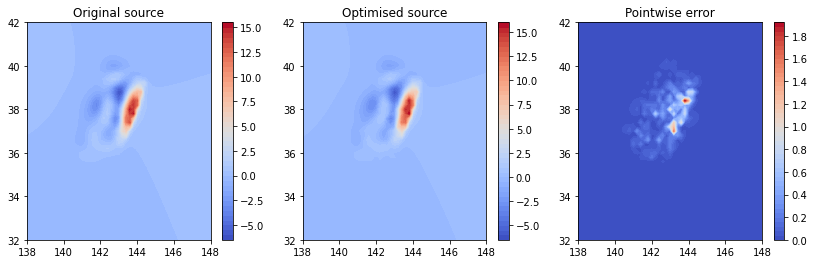

In [74]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
eta_pert = op.fault.dtopo.dZ.reshape(N, N)
fig.colorbar(axes[0].contourf(X, Y, eta, **plotting_kwargs), ax=axes[0]);
axes[0].set_title("Original source");
fig.colorbar(axes[1].contourf(X, Y, eta_pert, **plotting_kwargs), ax=axes[1]);
axes[1].set_title("Optimised source");
fig.colorbar(axes[2].contourf(X, Y, np.abs(eta - eta_pert), **plotting_kwargs), ax=axes[2]);
axes[2].set_title("Pointwise error");